## Решение уравнения переноса 

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = f(t, x)$$

$$c > 0$$

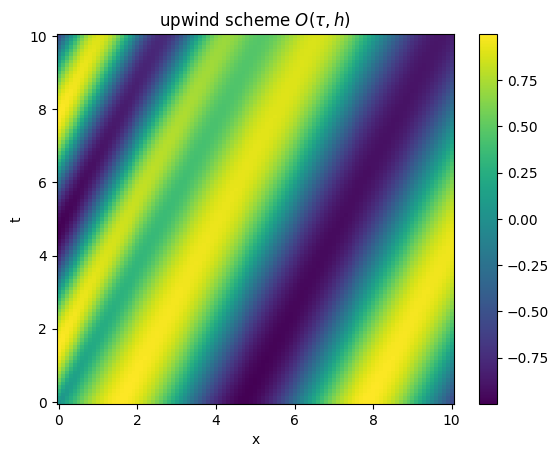

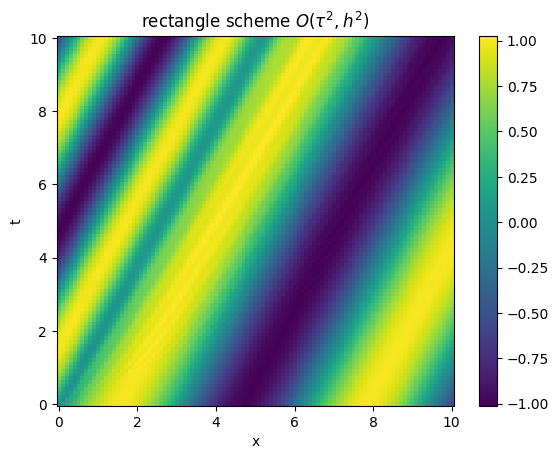

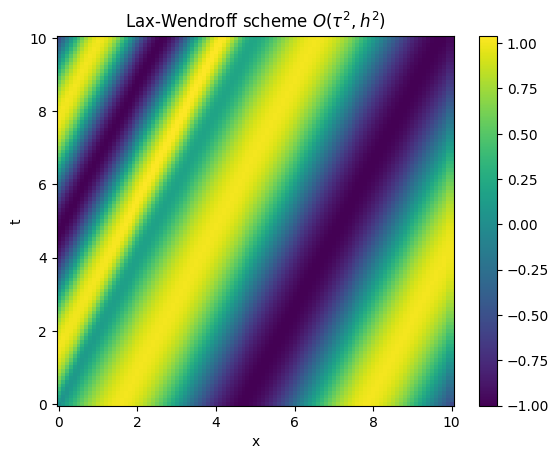

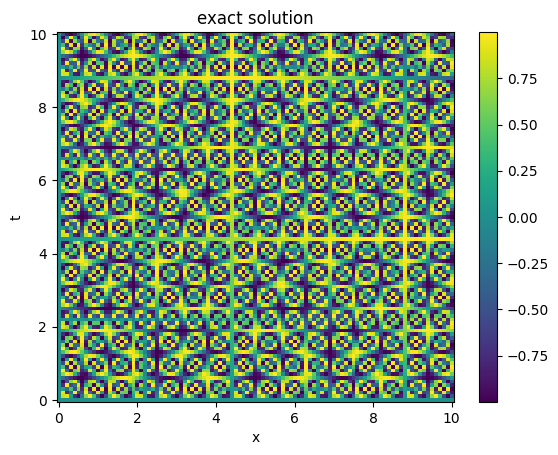

In [25]:
import matplotlib.pyplot as plt
from math import *


from typing import Callable
from dataclasses import dataclass
RtoR = Callable[[float], float]
R2toR = Callable[[float, float], float]

@dataclass
class Grid:
    # time
    T : float
    N : int
    # spatial
    L : float
    M : int

def __prepare(grid : Grid, phi : RtoR, psi : RtoR):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    u = [[phi(m*h) for m in range(grid.M + 1)]]
    for n in range(1, grid.N + 1):
        u += [[psi(tau*n)] + [0 for _ in range(grid.M)]]
    return tau, h, u

# solve u't + c*u'x = f(t, x)
# WARNING: c > 0
# u(0, x) = phi(x)
# u(t, 0) = psi(t)
def solve_by_upwind_scheme(c : float, grid : Grid, phi : RtoR, psi : RtoR, f : R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h # Courant number
    for n in range(grid.N):
        for m in range(1, grid.M + 1):
            u[n+1][m] = u[n][m] - cn*(u[n][m] - u[n][m-1]) + tau*f(tau * n, h * m)
    return u

def solve_by_rectangle_scheme(c : float, grid : Grid, phi : RtoR, psi : RtoR, f : R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h # Courant number
    ct = 1 / (1 + cn)
    ch = cn * ct
    cf = 2 * tau / (1 + cn)
    for n in range(grid.N):
        for m in range(1, grid.M + 1):
            f_nm = f(tau * (n + 0.5), h * (m - 0.5))
            u[n+1][m] = ct*(u[n][m] + u[n][m-1] - u[n+1][m-1]) - ch*(u[n][m] - u[n][m-1] - u[n+1][m-1]) + cf*f_nm
    return u

def solve_by_Lax_Wendroff_scheme(c: float, grid: Grid, phi: RtoR, psi: RtoR, f: R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h  # Courant number
    c1 = cn / 2
    c2 = cn*cn / 2
    for n in range(grid.N):
        for m in range(1, grid.M):
            u[n+1][m] = u[n][m] - c1*(u[n][m+1] - u[n][m-1]) + c2*(u[n][m+1] - 2*u[n][m] + u[n][m-1]) + tau * f(tau * n, h * m)
        u[n+1][grid.M] = u[n+1][grid.M - 1]  # todo
    return u

def phi(x : float):
    return sin(x)

def psi(t : float):
    return sin(t)

def f(t : float, x : float):
    return 0

grid = Grid(10, 100, 10, 100)

def show_result(u : list[list[float]], grid : Grid, title : str):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    plt.pcolormesh([h*m for m in range(grid.M + 1)], [tau*n for n in range(grid.N + 1)], u)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title(title)
    plt.colorbar()
    plt.show()


u = solve_by_upwind_scheme(0.5, grid, phi, psi, f)
show_result(u, grid, "upwind scheme $O(\\tau, h)$")
u = solve_by_rectangle_scheme(0.5, grid, phi, psi, f)
show_result(u, grid, "rectangle scheme $O(\\tau^2, h^2)$")
u = solve_by_Lax_Wendroff_scheme(0.5, grid, phi, psi, f)
show_result(u, grid, "Lax-Wendroff scheme $O(\\tau^2, h^2)$")
u = [[sin(m*n) for m in range(grid.M + 1)] for n in  range(grid.N + 1)]
show_result(u, grid, "exact solution")